# Time Series Analysis for Dynamical Systems


# 2. Preparing the environment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [37]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.56 s (started: 2024-09-13 14:20:22 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [38]:
#Local Installations
!pip install statsmodels

time: 1.56 s (started: 2024-09-13 14:20:23 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 0 ns (started: 2024-09-13 14:20:25 +02:00)


In [40]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 0 ns (started: 2024-09-13 14:20:25 +02:00)


In [41]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 0 ns (started: 2024-09-13 14:20:25 +02:00)


# 3. Pre-processing


In [42]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 14:20:25 +02:00)


In [43]:
data = read_Data()

time: 31 ms (started: 2024-09-13 14:20:25 +02:00)


In [44]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 235 ms (started: 2024-09-13 14:20:25 +02:00)


# SVM - III: Recursive Multi-Step-Forecasting with exogenous variables

## Organizing the Feature Matrix

# Forecasting further in time...

Lets use the SVM to predict further horizons by just using the training wisdom. Here we will follow a similar anology. We need to update the passed information about the past as we progress. Here, it is a bit more difficult as we need to update the created features as well. Lets see how it can be implemented.


In this section, the goal is to use the Support Vector Machine (SVM) model to make predictions further into the future. This process is called forecasting.

To accomplish this, we need to iteratively update the past information as we progress in time, making predictions for future time steps. This is a more challenging task because we also need to update the features used in the model as we move forward.

The basic idea can be summarized in the following steps:

1. `Train the SVM model on the available historical data.`
2. `Make a prediction for the next time step using the trained model.`
3. `Update the historical data and features with the new prediction.`
4. `Go back to step 2, using the updated historical data and features to make a prediction for the next time step.`

By repeating these steps, we can forecast further into the future while incorporating the information from previous predictions.

The significance of this approach is that it allows us to make predictions beyond the available test data, leveraging the "wisdom" gained from training the model on historical data. This is particularly useful when trying to anticipate trends, make business decisions, or plan for future events based on past patterns.

-----------------------------------------------------------------------------------------------------------------------------
    Here's a simplified, visual example to help you understand how to use an SVM model for forecasting further horizons by updating the input features for each prediction.

    Let's consider a simplified dataset containing only 3 features and the target variable (load) over 5 time steps:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load |
|-----------|-----------|-----------|-----------|------|
| 1         | 1         | 5         | 9         | 13   |
| 2         | 2         | 6         | 10        | 14   |
| 3         | 3         | 7         | 11        | 15   |
| 4         | 4         | 8         | 12        | 16   |
| 5         | 5         | 9         | 13        | 17   |

    We can use a sliding window of size 2 for this example. The dataset would be transformed into the following format:

| Time step | Feature 1_t1 | Feature 2_t1 | Feature 3_t1 | Feature 1_t2 | Feature 2_t2 | Feature 3_t2 | Load |
|-----------|--------------|--------------|--------------|--------------|--------------|--------------|------|
| 3         | 1            | 5            | 9            | 2            | 6            | 10           | 15   |
| 4         | 2            | 6            | 10           | 3            | 7            | 11           | 16   |
| 5         | 3            | 7            | 11           | 4            | 8            | 12           | 17   |

    Now, we train an SVM model using the transformed dataset. To forecast further horizons, we follow these steps:

    1. Train the SVM model on the available historical data.
    2. Make a prediction for the next time step (Time step 6) using the trained model and the last window of features from the historical data (i.e., [3, 7, 11, 4, 8, 12]).
    3. Update the historical data and features with the new prediction. In this case, we would replace the oldest data point (Time step 1) with the new prediction and shift the remaining data points up by one time step. We would also update the features accordingly.
    4. Repeat steps 2-3 to make predictions for further time steps.

    Here's an example of how the historical data and features would be updated after making a prediction for Time step 6:

| Time step | Feature 1 | Feature 2 | Feature 3 | Load    |
|-----------|-----------|-----------|-----------|---------|
| 2         | 2         | 6         | 10        | 14      |
| 3         | 3         | 7         | 11        | 15      |
| 4         | 4         | 8         | 12        | 16      |
| 5         | 5         | 9         | 13        | 17      |
| 6         | New_F1    | New_F2    | New_F3    | New_Load|

    By iteratively updating the historical data and features, we can forecast further into the future, leveraging the "wisdom" gained from training the model on historical data.

In [95]:
#Checking Data:
data.sample(3)

,load,T
2008-04-22 17:00:00,3394.0,72.33
2009-07-26 07:00:00,2553.0,67.33
2013-10-03 04:00:00,2267.0,53.33


time: 16 ms (started: 2024-04-03 09:08:57 +02:00)


In [45]:
# Step 1: Feature Engineering
# ---------------------------
# Extract only the 'load' data for statistical feature generation.
load_data = data[['load']]

# Set the rolling window width to 24 hours for calculating rolling statistics.
width = 24
window = load_data.rolling(window=width)

# Create a new DataFrame that includes rolling statistics and temperature data.
new_dataframe = pd.concat([window.median(), window.std(), data['T'], data['load']], axis=1)
new_dataframe.columns = ['median', 'std', 'T', 'load']
new_dataframe.dropna(inplace=True)
new_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78865 entries, 2006-01-01 23:00:00 to 2014-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   median  78865 non-null  float64
 1   std     78865 non-null  float64
 2   T       78865 non-null  float64
 3   load    78865 non-null  float64
dtypes: float64(4)
memory usage: 3.0 MB
time: 47 ms (started: 2024-09-13 14:20:31 +02:00)


In [46]:
new_dataframe.head(1)

,median,std,T,load
2006-01-01 23:00:00,3512.0,471.067697,24.33,3255.0


time: 16 ms (started: 2024-09-13 14:20:33 +02:00)


In [47]:
#finding the indices as integers for time substraction below:
start = np.where(new_dataframe.index == '2012-09-01 00:00:00')[0][0]
end = np.where(new_dataframe.index == '2014-11-04 00:00:00')[0][0]
#setting windows width:
window = 48
#emply datalist

# Step 3: Initialize lists for features, labels, and column names
dataX, dataY, column_names_list = [], [], []

for i in range(start,end-window):

    # Slice a window of features
    dataX.append((new_dataframe.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(new_dataframe['load'].iloc[i+window] )

for j in range (1,window+1):
      column_names_list.append(['median_t_'+str(j),'std_t_'+str(j),'T_t_'+str(j),'load_t_'+str(j)])

column_names = itertools.chain(*column_names_list)

dataX = pd.DataFrame(dataX, columns=column_names, index=new_dataframe.index[start + window:end])
dataY = pd.Series(dataY, name='true_load', index=new_dataframe.index[start + window:end])

time: 1.51 s (started: 2024-09-13 14:20:34 +02:00)


In [48]:
#Original DF:
new_dataframe.loc['2012-09-01 00:00:00':'2012-09-04 00:00:00'].head(6)

,median,std,T,load
2012-09-01 00:00:00,3750.5,593.535976,59.33,2719.0
2012-09-01 01:00:00,3750.5,588.651369,69.67,2817.0
2012-09-01 02:00:00,3750.5,584.145753,67.33,2664.0
2012-09-01 03:00:00,3750.5,580.500794,69.33,2580.0
2012-09-01 04:00:00,3750.5,577.913412,67.67,2537.0
2012-09-01 05:00:00,3750.5,581.252095,65.00,2525.0


time: 0 ns (started: 2024-09-13 14:20:35 +02:00)


In [49]:
dataX.head(2)

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2012-09-03 00:00:00,3750.5,593.535976,59.33,2719.0,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,...,64.67,3270.0,3107.5,400.451258,62.0,3070.0,3107.5,400.479656,60.00,2825.0
2012-09-03 01:00:00,3750.5,588.651369,69.67,2817.0,3750.5,584.145753,67.33,2664.0,3750.5,580.500794,...,62.00,3070.0,3107.5,400.479656,60.0,2825.0,3107.5,398.969315,64.67,2630.0


time: 16 ms (started: 2024-09-13 14:20:37 +02:00)


In [50]:
dataY.head(2)

2012-09-03 00:00:00    2630.0
2012-09-03 01:00:00    2403.0
Name: true_load, dtype: float64

time: 15 ms (started: 2024-09-13 14:20:38 +02:00)


In [51]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
count,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,...,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04,1.900800e+04
mean,4.126890e-16,-1.196200e-17,-1.674680e-16,1.226105e-16,1.943825e-16,1.256010e-16,-3.708220e-16,-3.289550e-17,-1.166295e-16,-1.913920e-16,...,1.555060e-16,-2.721355e-16,-5.741759e-16,-3.648410e-16,2.870880e-16,-1.854110e-16,6.339859e-16,2.631640e-16,-4.784800e-17,-1.764395e-16
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,...,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00
min,-2.311026e+00,-2.568864e+00,-3.149160e+00,-2.364007e+00,-2.310945e+00,-2.568901e+00,-3.149111e+00,-2.363968e+00,-2.310863e+00,-2.568927e+00,...,-3.148892e+00,-2.364704e+00,-2.310965e+00,-2.569386e+00,-3.148870e+00,-2.364718e+00,-2.311106e+00,-2.569493e+00,-3.148836e+00,-2.364747e+00
25%,-6.392120e-01,-6.328903e-01,-7.643083e-01,-7.708135e-01,-6.391302e-01,-6.328301e-01,-7.642519e-01,-7.707941e-01,-6.390483e-01,-6.327681e-01,...,-7.617216e-01,-7.714148e-01,-6.371107e-01,-6.309856e-01,-7.616627e-01,-7.714386e-01,-6.371837e-01,-6.308675e-01,-7.616067e-01,-7.714603e-01
50%,-1.347291e-01,-1.008269e-01,9.308555e-02,1.184520e-01,-1.354634e-01,-1.008014e-01,9.314447e-02,1.184610e-01,-1.361976e-01,-1.007916e-01,...,7.950615e-02,1.196863e-01,-1.357709e-01,-1.023340e-01,7.957783e-02,1.196574e-01,-1.358235e-01,-1.022454e-01,7.964181e-02,1.196396e-01
75%,6.215871e-01,4.280362e-01,7.966014e-01,6.798121e-01,6.212612e-01,4.280328e-01,7.966624e-01,6.798144e-01,6.213435e-01,4.278247e-01,...,8.007057e-01,6.792978e-01,6.219543e-01,4.269190e-01,8.007884e-01,6.792656e-01,6.219327e-01,4.268832e-01,8.008591e-01,6.792504e-01
max,4.123172e+00,4.490247e+00,2.443456e+00,3.418892e+00,4.123255e+00,4.490566e+00,2.443522e+00,3.418862e+00,4.123339e+00,4.490861e+00,...,2.449162e+00,3.418543e+00,4.124801e+00,4.495797e+00,2.449270e+00,3.418495e+00,4.124922e+00,4.495857e+00,2.449356e+00,3.418492e+00


time: 297 ms (started: 2024-09-13 14:20:39 +02:00)


In [52]:
#Temperature for weather forecasting (later used in multistep forecasting):
temp_test = dataX['T_t_1']
temp_test

2012-09-03 00:00:00    0.607728
2012-09-03 01:00:00    1.139868
2012-09-03 02:00:00    1.019441
2012-09-03 03:00:00    1.122370
2012-09-03 04:00:00    1.036939
                         ...   
2014-11-03 19:00:00   -0.490004
2014-11-03 20:00:00   -0.506987
2014-11-03 21:00:00   -0.506987
2014-11-03 22:00:00   -0.506987
2014-11-03 23:00:00   -0.490004
Name: T_t_1, Length: 19008, dtype: float64

time: 0 ns (started: 2024-09-13 14:20:40 +02:00)


In [53]:
# Step 4: Splitting the Data for Training and Testing
# ----------------------------------------------------
train_start_dt = '2014-10-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'
#Lets use the same notation: X_train, X_test, y_train, y_test
X_train = dataX.copy()[(dataX.index >= train_start_dt)& (dataX.index < test_start_dt)]
y_train = dataY.copy()[(dataY.index >= train_start_dt)& (dataY.index < test_start_dt)]

X_test =  dataX.copy()[(dataX.index >= test_start_dt) & (dataX.index < test_end_dt)]
y_test =  dataY.copy()[(dataY.index >= test_start_dt) & (dataY.index < test_end_dt)]


print('Train data shape: ', X_train.shape, y_train.shape)
print('Test data shape: ', X_test.shape, y_test.shape)

Train data shape:  (744, 192) (744,)
Test data shape:  (72, 192) (72,)
time: 16 ms (started: 2024-09-13 14:20:42 +02:00)


In [54]:
# Initialize a list to store the last 'load' values used for updating the features.
s_window = 24  # This represents the sliding window size for capturing recent load history.
last_loads = list()

# Extract the first set of features from the test data to initialize the forecasting process.
X_last = X_test.iloc[0:1]

X_last.tail()

,median_t_1,std_t_1,T_t_1,load_t_1,median_t_2,std_t_2,T_t_2,load_t_2,median_t_3,std_t_3,...,T_t_46,load_t_46,median_t_47,std_t_47,T_t_47,load_t_47,median_t_48,std_t_48,T_t_48,load_t_48
2014-11-01,-0.129831,0.115119,-0.335611,-1.054167,-0.129749,0.109072,0.024697,-1.428379,-0.129667,0.107447,...,-0.246579,0.016319,-0.651808,-0.985907,-0.229512,-0.292029,-0.651882,-0.963692,-0.332482,-0.734034


time: 16 ms (started: 2024-09-13 14:20:43 +02:00)


In [55]:
# Populate the 'last_loads' list with the most recent 'load' values from 'X_last'.
# These values will be updated as new predictions are made and used to update future feature sets.
for i in range(1, s_window + 1):
    column = 'load_t_' + str(i)
    last_loads.append(X_last[column][0])
last_loads = np.array(last_loads)
last_loads

array([-1.05416662, -1.42837947, -1.5815736 , -1.65635407, -1.63669901,
       -1.46024993, -0.97911984, -0.06322531,  0.38045911,  0.3893592 ,
        0.40895085,  0.32341297,  0.25213262,  0.1594695 ,  0.15768899,
        0.10067245,  0.08108038,  0.17552834,  0.44815689,  0.75818488,
        0.6637238 ,  0.46593522,  0.02047563, -0.57643783])

time: 0 ns (started: 2024-09-13 14:20:45 +02:00)


In [56]:
# Step 2: Predicting Future Loads
# ----------------------------------
# Initialize a Series to store predictions.
y_predicted = pd.Series(index=y_test.index)

time: 0 ns (started: 2024-09-13 14:20:46 +02:00)


In [57]:
#import lib
from pandas.tseries.offsets import DateOffset

time: 16 ms (started: 2024-09-13 14:20:47 +02:00)


In [58]:
# Convert the initial test features to numpy array for processing.
X_test_last = X_last.to_numpy()
X_test_last.shape

(1, 192)

time: 0 ns (started: 2024-09-13 14:20:48 +02:00)


In [110]:
X_test_last

array([[-1.29831251e-01,  1.15119221e-01, -3.35611380e-01,
        -1.05416662e+00, -1.29749182e-01,  1.09071635e-01,
         2.46968596e-02, -1.42837947e+00, -1.29667114e-01,
         1.07446998e-01, -6.11655152e-02, -1.58157360e+00,
        -1.29585046e-01,  1.02084079e-01, -1.64022169e-01,
        -1.65635407e+00, -1.29502980e-01,  9.40726648e-02,
        -2.32393598e-01, -1.63669901e+00, -1.29420914e-01,
         8.46275089e-02, -2.83785718e-01, -1.46024993e+00,
        -1.29338849e-01,  7.56909748e-02, -3.52168961e-01,
        -9.79119835e-01, -1.29256785e-01,  7.81966328e-02,
        -3.69599832e-01, -6.32253087e-02, -9.32567418e-02,
         8.91679337e-02, -4.37989350e-01,  3.80459106e-01,
        -9.31746653e-02,  9.17253913e-02, -4.20936176e-01,
         3.89359202e-01, -9.31063467e-02,  8.96481911e-02,
        -2.48943916e-01,  4.08950853e-01, -1.27356740e-01,
         6.19661433e-02, -9.44422956e-02,  3.23412970e-01,
        -1.81214266e-01,  3.36424089e-02,  1.11549330e-0

time: 0 ns (started: 2024-04-03 09:08:59 +02:00)


In [59]:
# Iterate over the test data indices to make predictions and update the features accordingly.
n_features = 4  # Number of features used in prediction (median, std, temp, load)
dummy_array = np.zeros((1, X_test_last.shape[1]))  # Helper array for feature scaling

time: 0 ns (started: 2024-09-13 14:20:51 +02:00)


In [60]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

time: 0 ns (started: 2024-09-13 14:20:53 +02:00)


In [61]:
# Model Training:
model = svr
#Fitting the model according to given data:
model.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 47 ms (started: 2024-09-13 14:20:54 +02:00)


In [62]:
# Debugging: Print the start and end of the temp_test to verify the range
print(f"Start of temp_test: {temp_test.index.min()}")
print(f"End of temp_test: {temp_test.index.max()}")

# Iterate over the test data indices to make predictions and update the features accordingly
case_indices = y_test.index
for case_index in case_indices:
    # print(f"Processing case_index: {case_index}")  # Debugging: current index being processed
    
    # Predict the load using the SVM model and update 'y_predicted' Series
    load_prediction = svr.predict(X_test_last).flatten()[0]
    y_predicted.update(pd.Series(load_prediction, index=[case_index]))
    
    # Scale the predicted 'load' for feature update
    dummy_array = np.zeros((1, X_test_last.shape[1]))
    dummy_array[0, -1] = load_prediction  # Assuming the last column in X_test_last is 'load'
    load_scaled = sX.transform(dummy_array)[0, -1]
    
    # Update the 'last_loads' list with the new prediction
    last_loads = np.roll(last_loads, -1)
    last_loads[-1] = load_scaled
    
    # Compute new statistical features based on updated 'last_loads'
    median_i = np.median(last_loads)
    std_i = np.std(last_loads)
    
    # Handle temperature feature update with checks for missing timestamps
    time_index = pd.Timestamp(case_index) + DateOffset(hours=1)
    print(f"Looking for temperature at: {time_index}")  # Debugging: intended temperature timestamp
    
    if time_index in temp_test.index:
        temp_i = temp_test.loc[time_index]
    else:
        print(f"Timestamp {time_index} not found in temp_test. Using the last known temperature.")
        temp_i = temp_test.iloc[-1]  # Fallback if timestamp not found
    
    # Update features in 'X_test_last' for the next prediction
    X_test_last = np.roll(X_test_last, -4)  # Assuming 4 features: median, std, T, load
    X_test_last[0, -4:] = [median_i, std_i, temp_i, load_scaled]

# At the end of this loop, 'y_predicted' will contain all the load predictions

Start of temp_test: 2012-09-03 00:00:00
End of temp_test: 2014-11-03 23:00:00
Looking for temperature at: 2014-11-01 01:00:00
Looking for temperature at: 2014-11-01 02:00:00
Looking for temperature at: 2014-11-01 03:00:00
Looking for temperature at: 2014-11-01 04:00:00
Looking for temperature at: 2014-11-01 05:00:00
Looking for temperature at: 2014-11-01 06:00:00
Looking for temperature at: 2014-11-01 07:00:00
Looking for temperature at: 2014-11-01 08:00:00
Looking for temperature at: 2014-11-01 09:00:00
Looking for temperature at: 2014-11-01 10:00:00
Looking for temperature at: 2014-11-01 11:00:00
Looking for temperature at: 2014-11-01 12:00:00
Looking for temperature at: 2014-11-01 13:00:00
Looking for temperature at: 2014-11-01 14:00:00
Looking for temperature at: 2014-11-01 15:00:00
Looking for temperature at: 2014-11-01 16:00:00
Looking for temperature at: 2014-11-01 17:00:00
Looking for temperature at: 2014-11-01 18:00:00
Looking for temperature at: 2014-11-01 19:00:00
Looking fo

c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\JuanFernandez\anaconda3\envs\energy_portfolio_management\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have vali

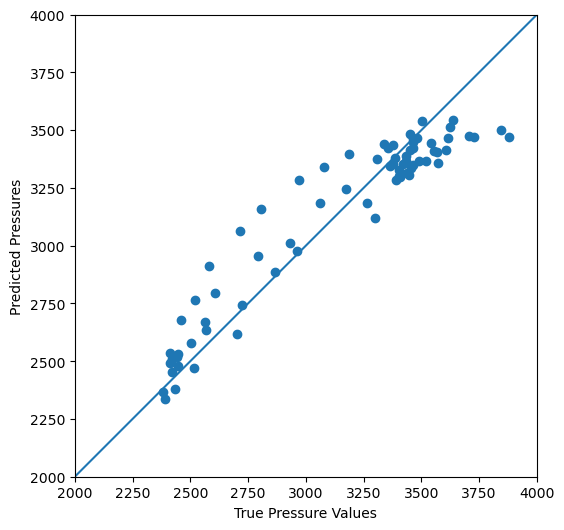

time: 109 ms (started: 2024-09-13 14:21:01 +02:00)


In [63]:
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_predicted)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [2000, 4000]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

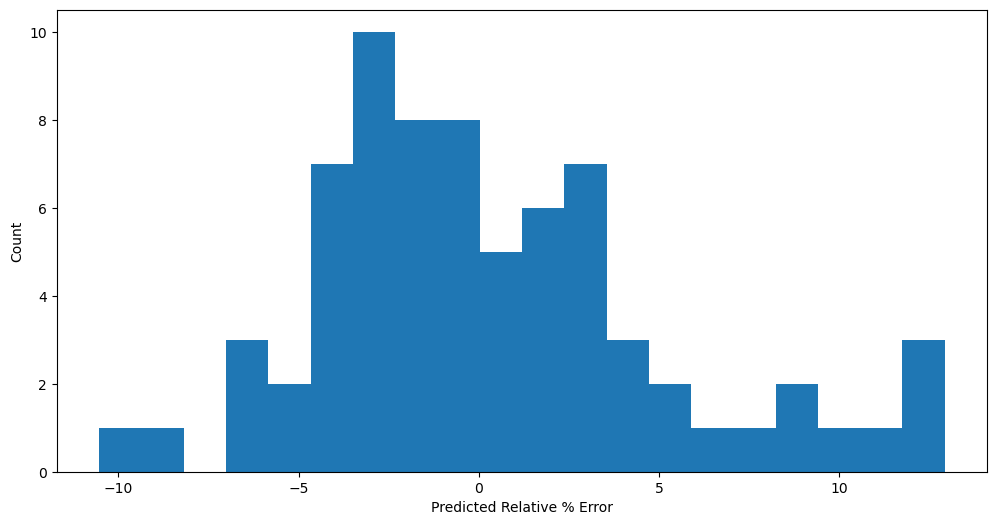

time: 93 ms (started: 2024-09-13 14:21:03 +02:00)


In [64]:
# Calculating the error variations:
error_nn = (y_predicted - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [65]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(y_predicted - y_test)/y_test*100
np.average(error_nn)

0.3003404758695368

time: 0 ns (started: 2024-09-13 14:21:05 +02:00)


In [66]:
#Calculating R2 value:
r2_test = r2_score(y_test, y_predicted)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.89
time: 0 ns (started: 2024-09-13 14:21:06 +02:00)


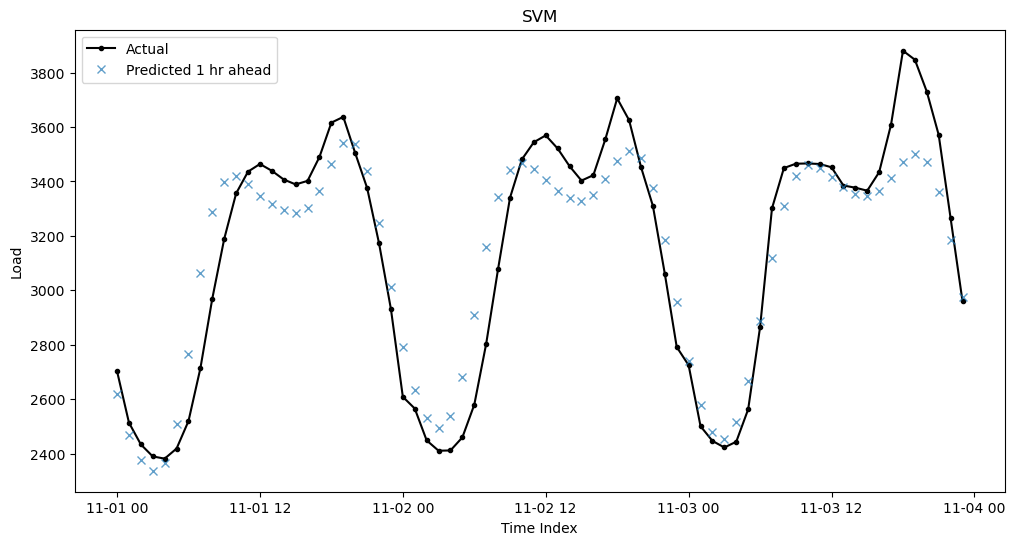

time: 141 ms (started: 2024-09-13 14:21:08 +02:00)


In [67]:
#Plotting the Figure: 
plt.figure();
plt.plot(y_test, 'k.-');
plt.plot(y_predicted, 'x', alpha=0.70);

plt.legend(['Actual',
            'Predicted 1 hr ahead'
            ]);
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SVM');
mpl.rcParams['figure.figsize'] = [12.0, 6.0]

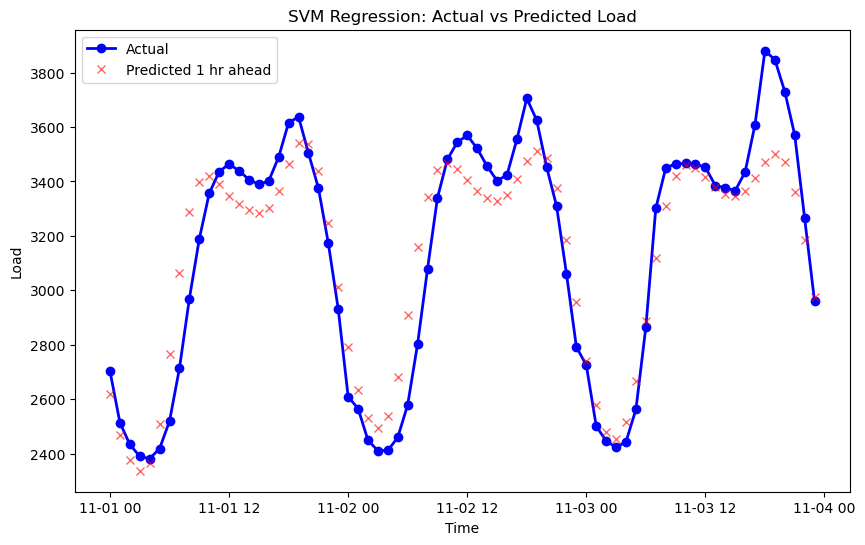

time: 125 ms (started: 2024-09-13 14:21:10 +02:00)


In [68]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(y_predicted.index, y_predicted, label='Predicted 1 hr ahead', color='red', alpha=0.6, marker='x', linestyle='None')
plt.title('SVM Regression: Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()